# Abstract

Traffic congestion is a problem that drivers all over the world contend with. Solutions have frequently involved adding more lanes and building more infrastructure that supports cars, but new technology suggests a new path forward. Electronic bikes, or e-bikes, are bicycles that are assisted in their motion by electric motors. They are rapidly increasing in popularity due to their relative low cost compared to cars, their benefits to fighting climate change by using electricity instead of gasoline, and their ease of use. Given that e-bikes can replace cars, especially in big cities in which speed limits for cars are relatively low, it would be beneficial to replan our road systems to account for this. Hypothetically, New York City is planning on replacing one lane on each of its roads with at least 2 lanes on the island of Manhattan with a bike-only lane. Specifically, this will be accomplished by taking the lane closest to the sidewalk, returning half of it to the sidewalk, and reserving the smaller lane for bicycles alone. The goal of this simulation is to determine if doing so will reduce emissions on the roads without negatively affecting traffic throughput. I will be implementing this using CityFlow and hope the following notebook can both illustrate the benefits of encouraging e-bike use and also offer a tutorial into the use of CityFlow as a powerful simulation tool.

# Conceptual Model

## Abstraction:

The conceptual model uses a series of intersecting queues. Each lane in the map is one queue, and each traffic light is a server. One important note is that the queues start and end at intersections. This means although a road is contiguous in real life, CityFlow represents it as a series of different queues. Different lanes have different limits on the number of vehicles that can fit depending on both the size of the vehicles and the lanes. A vehicle's progression to the system consists of transferring between queues until the vehicle's route is complete. Queue transfers can only occur if there is space in the new queue, the two queues are connected through an intersection, and the traffic light (server) allows the transfer to occur. At an intersection, not all lanes can be connected to the other lanes. The limits are set through limiting lanes to being turn lanes or non-turn lanes. Traffic lights are set to the same cycle time of 30 seconds and only cars and bikes are considered as examples of vehicles. The roads considered are the roads on the island of Manhattan, including the boroughs of Manhattan and The Bronx. All cars are considered to be the same size as are all bicycles. The specifics of those numbers can be found later in the notebook.

Below is a snippet of the Manhattan map, zoomed in to show the traffic lights and lanes. 

![Roadnet Snippet](nb_images/roadnet.png)


## Inputs:

The inputs to the model are the configurations of the vehicles, the specific map used, and the series of traffic flows the model needs to perform. Example vehicle configurations are provided below and can be adjusted easily. The specific maps used are also provided in the roadnet_files directory. As will be described later, there are two different maps being considered which each have different configurations of lanes that reflect both current road structure and the proposed lane conversion. The traffic flows describe both the origin and destination of each vehicle as well as waypoints along the routes. This is pulled from real-world traffic data.


## Outputs:

The outputs of the model are the various metrics that I choose to measure. These metrics are:

**Active Vehicles**: This measures the number of active vehicles in the simulation at each timestep. An active vehicle is a vehicle that is en route to it's destination and that has not yet arrived and been removed from the simulation.

**Average Travel Time**: This measures the average time each vehicle spends traveling in the simulation. As will be described later, this is split before and after the time at which no new vehicles are introduced.

**Emissions**: This measures the emissions released by the cars on the road. The specific value I am measuring is the total travel time for all the cars, but this acts as a useful proxy for emissions calculations. The longer cars spend on the road, the more emissions they release.

# Code Setup

CityFlow code: https://github.com/cityflow-project/CityFlow

CityFlow documentation: https://cityflow.readthedocs.io/en/latest/index.html

I am using the CityFlow library, which provides a simulation environment in which to run the experiments I will describe later. However, I discovered some bugs in the code and had to make further modifications given the specific problem I am trying to solve. For this reason, installing the CityFlow library off the internet will not yield the same results. I have included the modified CityFlow code in the GitHub repository. To install this, run the following commands from the root directory:

In order for the CityFlow submodule to be included in the cloned code, please run the following git clone command:

`git clone --recurse-submodules https://github.gatech.edu/akumar437/4230-project`

Note: Linux and Python version at or equal 3.5 required.

`sudo apt update && sudo apt install -y build-essential cmake`

`cd CityFlow`

`pip install .`

That will install CityFlow. To install the other needed packages, run:

`pip install tqdm matplotlib numpy pandas seaborn'

# Code

In [22]:
import cityflow
import json
from tqdm.notebook import tqdm
from copy import deepcopy
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(4230)
sns.set()

## Vehicle Configurations
CityFlow provides a configuration format to specify the statistics of the different vehicles in the simulation. These options will affect the simulation results in ways that I will explain further in the Results section. There are options to control the size of the vehicles, how they accelerate, and the gap they maintain with other vehicles on the road. The units are in meters.

In [23]:
vehicles = {
    'ebike' : {
        "length": 1.72,
        "width": 1.0,
        "maxPosAcc": 1.0,
        "maxNegAcc": 2.0,
        "usualPosAcc": 1.0,
        "usualNegAcc": 2.0,
        "minGap": 1.2,
        "maxSpeed": 9,
        "headwayTime": 2,
        "vehicleType": "ebike"
    },
    'car' : {
        "length": 5.0,
        "width": 2.0,
        "maxPosAcc": 2.0,
        "maxNegAcc": 4.5,
        "usualPosAcc": 2.0,
        "usualNegAcc": 4.5,
        "minGap": 2.5,
        "maxSpeed": 11.111,
        "headwayTime": 2,
        "vehicleType": "car"
    }
}

<br>

## Create Adjusted Map

I was able to find a CityFlow compliant map of Manhattan Island from https://github.com/Chacha-Chen/MPLight. I then needed to edit the map in order to reflect the changes I was proposing. The map is structured as set of intersections and roads, which together define the topology of the map. What I am editing is the lanes, which are accessible through the roads component of the map, otherwise known as a roadnet. What I am doing is removing the rightmost lane and replacing it with one half as wide. 

In [4]:
with open('roadnet_files/manhattan_default.json', 'r') as file:
    roadnet = json.load(file)
    for i in range(len(roadnet['roads'])):
        lanes = roadnet['roads'][i]['lanes']
        if len(lanes) > 1:
            del roadnet['roads'][i]['lanes'][-1]
            roadnet['roads'][i]['lanes'].append({"width": 2, "maxSpeed": 11.111})
with open('roadnet_files/manhattan_ebike.json', 'w') as file:
    json.dump(roadnet, file, indent=4)

<br>

## Load Traffic Flow Data

The same repository from which I found the Manhattan Island map also had some historic data regarding traffic flow pulled from taxi cab data. The data was then scaled up to match the total volume of cars found in Manhattan. The approach I used was to randomly sample these traffic flows and assign them to e-bikes or cars. I used different probabilities to see how my chosen metrics would change with the proportion of traffic that e-bikes accounted for

In [24]:
with open(f'raw_flow_files/manhattan_31217.json', 'r') as file:
    original_flow = json.load(file)

<br>

## Function to Randomly Assign Flows to Vehicle Types

The function below samples the flows from the flow file that will be turned into e-bike flows. 

In [25]:
def gen_flow_p(p, original_flow):
    new_flow = deepcopy(original_flow)
    random.shuffle(new_flow)
    split = int(p * len(original_flow))
    for i in range(len(new_flow)):
        vehicle_type = 'ebike' if i < split else 'car'
        new_flow[i]['vehicle'] = vehicles[vehicle_type]
    with open(f"processed_flow_files/manhattan_{p}.json", 'w') as file:
        json.dump(new_flow, file, indent=4)

In [ ]:
#Generate the randomly sampled vehicle flows
for p in [1, .75, .5, .2, .1, 0]:
    gen_flow_p(p, original_flow)

<br>

## Simulation Loop

The following code block contains the bulk of the simulation code. I ran 10 trials, split into two roadnets. The first is the default Manhattan map to use as a control. The second is the modified map to include the bike-only lanes. For each map, I ran 5 experiments with different probabilities of e-bikes for sampling. The goal is to observe how different amounts of e-bikes affect traffic flow as well as the effects of modifying road structures. Running the 5 configurations for each map provides rigorous control experiments for each proposed change.

In [ ]:
#Set the number of iterations the simulations will run for.
NUM_ITERATIONS=60*60*6

for roadnet in ['default', 'ebike']:
    for p in [1, .75, .5, .2, .1, 0]:
        
        #Generate the randomly sampled vehicle flows
        
        data = {}
        #This config json contains information like determining how much time a simulation step accounts for, the specific map and flows used, as well as other options
        config = {
            "interval": 1.0,
            "seed": 0,
            "dir": "./",
            "roadnetFile": f"roadnet_files/manhattan_{roadnet}.json",
            "flowFile": f"processed_flow_files/manhattan_{p}.json",
            "rlTrafficLight": False,
            "saveReplay": False,
            "laneChange": True
        }
        #The config file needs to be dumped to json to be passed in to the Engine class
        with open(f'config_files/config_{roadnet}_{p}.json', 'w') as file:
            json.dump(config, file, indent=4)
        eng = cityflow.Engine(f'config_files/config_{roadnet}_{p}.json', thread_num=8)
        
        #Initializing empty dictionaries to store data
        data['vehicle_counts'] = []
        data['vehicle_travel_time_startup'] = {}
        data['vehicle_travel_time_post_startup'] = {}
        data['vehicle_type'] = {}
        emission_calc = 0
        
        for i in tqdm(range(NUM_ITERATIONS)):
            #Returns the travel time for all vehicles still in the simulation
            vehicle_travel_time = eng.get_vehicle_time()
            
            #Splitting the travel time logging by whether or not the simulation is still in the start-up period.
            if i < 3879:
                travel_time_dict = 'vehicle_travel_time_startup'
            else:
                travel_time_dict = 'vehicle_travel_time_post_startup'
            
            #Store the travel time that was measured by the simulation engine. Also store the type of vehicle for future analysis.
            for vehicle_id in vehicle_travel_time:
                data[travel_time_dict][vehicle_id] = vehicle_travel_time[vehicle_id]
                info = eng.get_vehicle_info(vehicle_id)
                if vehicle_id not in data['vehicle_type']:
                    data['vehicle_type'][vehicle_id] = info['vehicleType']
            #Advances the simulation
            eng.next_step()
            
            #Stores the number of vehicles active in the simulation
            data['vehicle_counts'].append(eng.get_vehicle_count())
        
        #Run the time measurement step for the last time to capture the information after the final simulation step has run
        vehicle_travel_time = eng.get_vehicle_time()
        data['vehicle_travel_eng'] = vehicle_travel_time
        for vehicle_id in vehicle_travel_time:
            data['vehicle_travel_time_post_startup'][vehicle_id] = vehicle_travel_time[vehicle_id]
            info = eng.get_vehicle_info(vehicle_id)
            if vehicle_id not in data['vehicle_type']:
                data['vehicle_type'][vehicle_id] = info['vehicleType']

        #Calculate the total emissions, but only add if the vehicle is a car.
        for vehicle_id in data['vehicle_type']:
            if data['vehicle_type'][vehicle_id] == 'car' and vehicle_id in data['vehicle_travel_time_post_startup']:
                emission_calc += data['vehicle_travel_time_post_startup'][vehicle_id]
            if data['vehicle_type'][vehicle_id] == 'car' and vehicle_id in data['vehicle_travel_time_startup'] and vehicle_id not in data['vehicle_travel_time_post_startup']:
                emission_calc += data['vehicle_travel_time_startup'][vehicle_id]
        data['emission_calc'] = emission_calc
        
        #Dump to a file to store. Useful if only running subset of simulation steps at a time
        with open(f'data_dump/data_dump_{roadnet}_{p}.pkl', 'wb') as file:
            pickle.dump(data, file)

<br>

# Results

In [3]:
#Load the logged data from the dumped pickle files
default_data = {'default': {}, 'ebike': {}}
for p in [0, .1, .2, .5, .75, 1]:
    with open(f'data_dump/data_dump_default_{p}.pkl', 'rb') as f:
        default_data['default'][p] = pickle.load(f)
    with open(f'data_dump/data_dump_ebike_{p}.pkl', 'rb') as f:
        default_data['ebike'][p] = pickle.load(f)

In [4]:
#Initialize lists to store the plot data
final_counts_default = []
final_counts_ebike = []
max_counts_default = []
max_counts_ebike = []
final_max_diff_default = []
final_max_diff_ebike = []
bar_p = []
bar_roadnet = []
emissions_val = []
time_val = []

for roadnet in ['default', 'ebike']:
    for p in default_data[roadnet]:
        #Calculate the maximum and final vehicle counts
        final_count = default_data[roadnet][p]['vehicle_counts'][-1]
        max_count = max(default_data[roadnet][p]['vehicle_counts'])
        
        #Store the p values for the bar chart
        bar_p.append(p)
        bar_roadnet.append(roadnet)
        
        #Store the emissions and travel time values for the charts
        emissions_val.append(default_data[roadnet][p]['emission_calc'])
        travel_time = np.mean(list(default_data[roadnet][p]['vehicle_travel_time_post_startup'].values()))
        time_val.append(travel_time)
        
        #Split the data by map
        if roadnet == 'default':
            final_counts_default.append((final_count, p))
            max_counts_default.append((max_count, p))
            final_max_diff_default.append(((max_count-final_count)/17720, p))
        else:
            final_counts_ebike.append((final_count, p))
            max_counts_ebike.append((max_count, p))
            final_max_diff_ebike.append(((max_count-final_count)/17720, p))
        
        #Store the travel time values, excluding the data from the start-up period
        car_time = []
        ebike_time = []
        for vehicle_id in default_data[roadnet][p]['vehicle_travel_time_post_startup']:
            if default_data[roadnet][p]['vehicle_type'][vehicle_id] == 'car':
                car_time.append(default_data[roadnet][p]['vehicle_travel_time_post_startup'][vehicle_id])
            elif default_data[roadnet][p]['vehicle_type'][vehicle_id] == 'ebike':
                ebike_time.append(default_data[roadnet][p]['vehicle_travel_time_post_startup'][vehicle_id])
                
        #Calculate the mean travel time. Initialize at 0 in case of an empty list. This can occur when probabilities are 0/1.
        default_data[roadnet][p]['mean_ebike_time'] = 0
        default_data[roadnet][p]['mean_car_time'] = 0
        if len(ebike_time) > 0:
            default_data[roadnet][p]['mean_ebike_time'] = np.mean(ebike_time)
        if len(car_time) > 0:
            default_data[roadnet][p]['mean_car_time'] = np.mean(car_time)

<br>

## Tracking Active Vehicle Counts over Time on Default Map

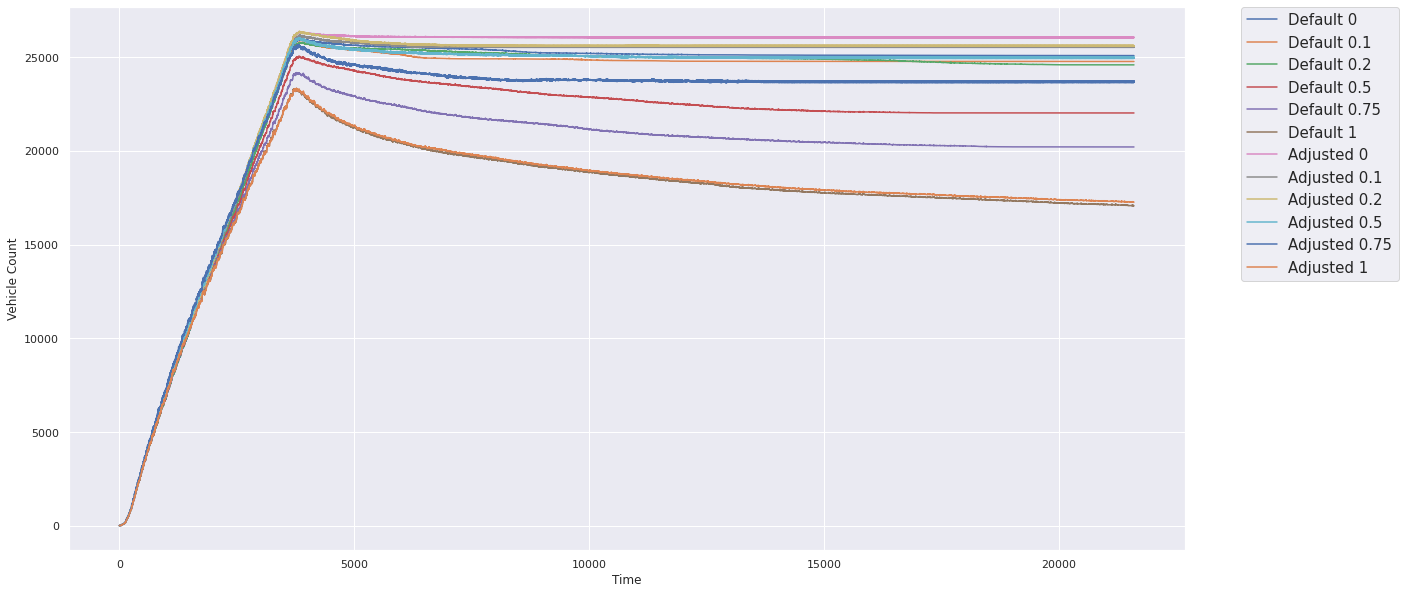

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.set_xlabel('Time')
ax.set_ylabel('Vehicle Count')
for roadnet in ['default', 'ebike']:
    for p in default_data[roadnet]:
        if roadnet == 'ebike':
            sns.lineplot(x=range(len(default_data[roadnet][p]['vehicle_counts'])), y=default_data[roadnet][p]['vehicle_counts'], label=f'Adjusted {p}', ax=ax)
        else:
            sns.lineplot(x=range(len(default_data[roadnet][p]['vehicle_counts'])), y=default_data[roadnet][p]['vehicle_counts'], label=f'{roadnet.capitalize()} {p}', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

The above figure charts how many vehicles are actively moving in the simulation over time. Runs with different probabilities of flows being ebikes have different lines. As can be seen, all of the lines have a start up period in which new vehicles are introduced to the simulation. Following that start up period, the number of vehicles starts to decrease. The data show that as the proportion of e-bikes on the road increases, vehicles are able to more quickly move through the simulation and there are fewer active vehicles on the road. The reason for the maximum values being different for each probability is that as the start up period is ongoing, vehicles are still leaving the simulation. The data also show that the e-bike focused map improve the throughput by reducing the active vehicles present in the simulation at any given time. This means more vehicles are completing their routes. This suggests that focusing on e-bikes improves traffic flow. 

<br>

## Best Vehicle Count Runs from Each Map

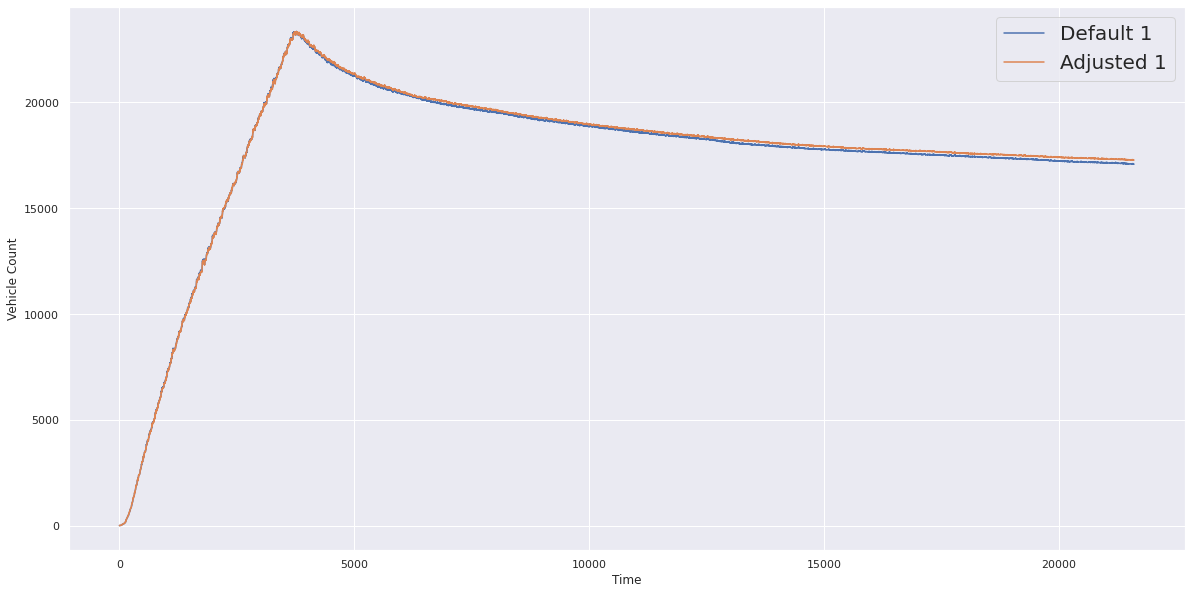

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.set_xlabel('Time')
ax.set_ylabel('Vehicle Count')
final_counts_default = sorted(final_counts_default)
final_counts_ebike = sorted(final_counts_ebike)
default_p = final_counts_default[0][1]
ebike_p = final_counts_ebike[0][1]
sns.lineplot(x=range(len(default_data['default'][default_p]['vehicle_counts'])), y=default_data['default'][default_p]['vehicle_counts'], legend='brief', label=f'Default {p}', ax=ax)
sns.lineplot(x=range(len(default_data['ebike'][ebike_p]['vehicle_counts'])), y=default_data['ebike'][ebike_p]['vehicle_counts'], legend='brief', label=f'Adjusted {p}', ax=ax)
ax.legend(prop={'size': 20})

The above figure shows the best results, defined by lowest final vehicle count, on both maps. Both occur with the probability of e-bikes equal to 1, showing the potential e-bieks have for reducing congestion.

<br>

## Tracking Final Active Vehicle Counts over Time

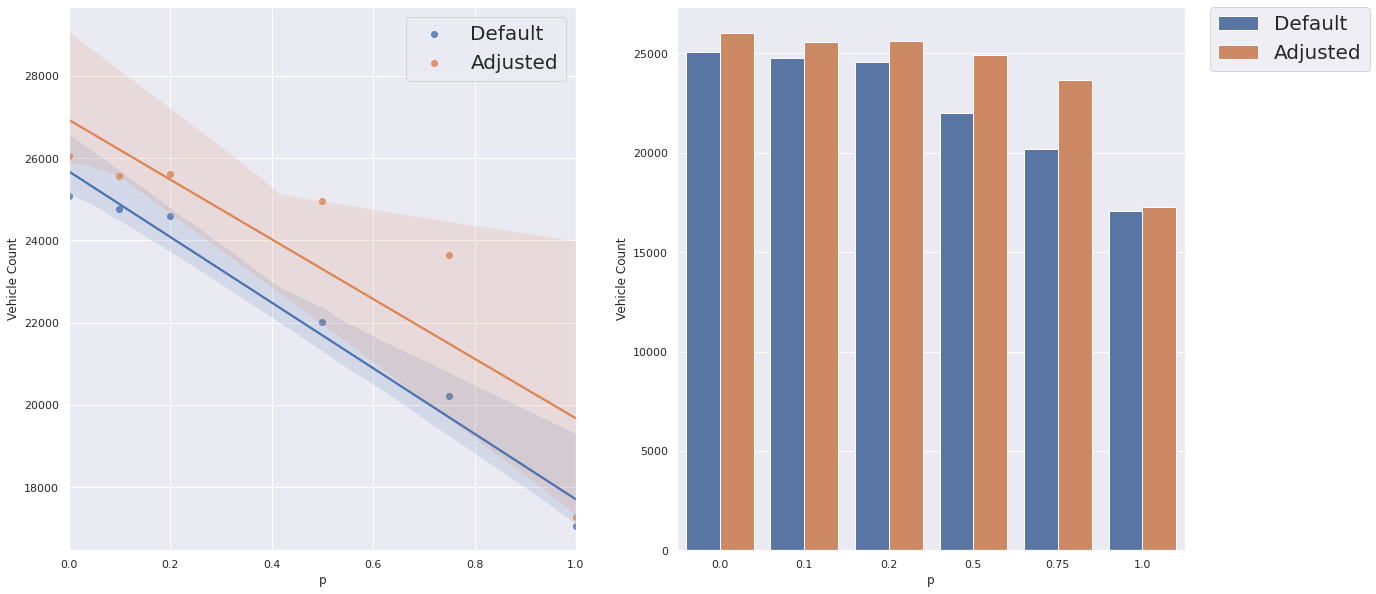

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Vehicle Count')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Vehicle Count')
final_vehicle_count_default, final_p_default = list(zip(*final_counts_default))
sns.regplot(x=list(final_p_default), y=list(final_vehicle_count_default), label='Default', ax=axes[0])
final_vehicle_count_ebike, final_p_ebike = list(zip(*final_counts_ebike))
sns.regplot(x=list(final_p_ebike), y=list(final_vehicle_count_ebike), label='Adjusted', ax=axes[0])
sns.barplot(x=list(final_p_default)+list(final_p_ebike), y=list(final_vehicle_count_default) + list(final_vehicle_count_ebike), hue=['Default' for i in range(len(final_p_default))] + ['Adjusted' for i in range(len(final_p_ebike))], ax=axes[1])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
axes[0].legend(prop={'size': 20})

This plot shows the relationship between the percentage of e-bike ridership and the final vehicle count at the end of the simulation. As can be seen, there is a clear correlation between the two. However, there are more active vehicles in the adjusted map. This could be due to the need for cars to merge into bike lanes, therefore requiring them to wait until there is space in the bike lanes and holding up the traffic behind them.

<br>

## Tracking Active Vehicle Count Decrease Rate over Time

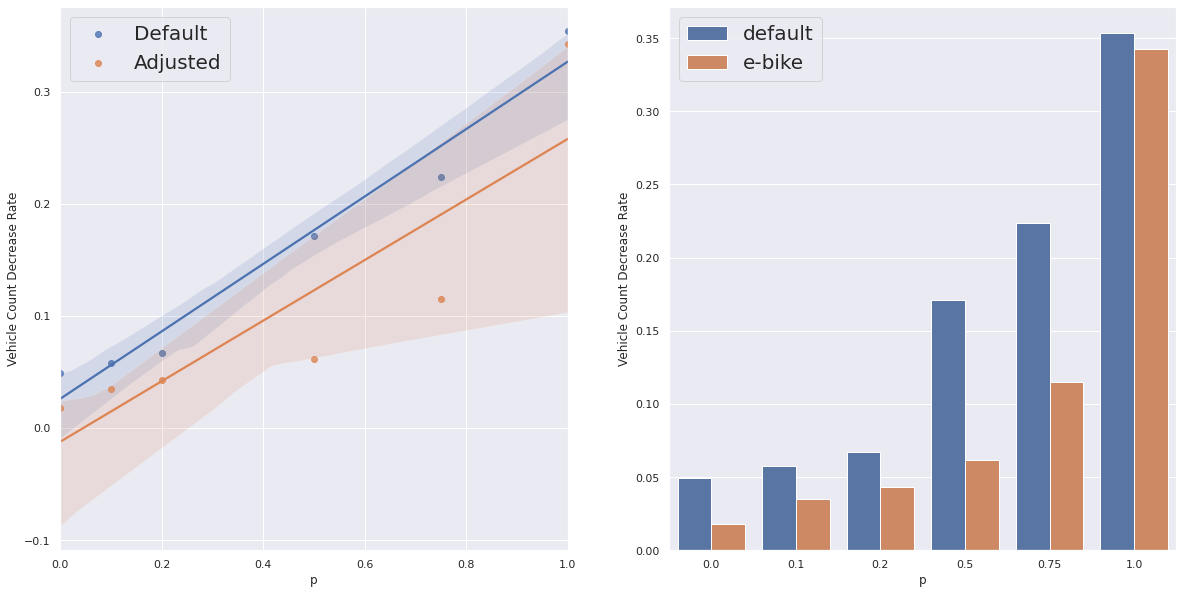

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Vehicle Count Decrease Rate')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Vehicle Count Decrease Rate')
final_max_diff_default, final_p_diff_default = list(zip(*final_max_diff_default))
sns.regplot(x=list(final_p_diff_default), y=list(final_max_diff_default), label='Default', ax=axes[0])
final_max_diff_ebike, final_p_diff_ebike = list(zip(*final_max_diff_ebike))
sns.regplot(x=list(final_p_diff_ebike), y=list(final_max_diff_ebike), label='Adjusted', ax=axes[0])
sns.barplot(x=list(final_p_diff_default)+list(final_p_diff_ebike), y=list(final_max_diff_default) + list(final_max_diff_ebike), hue=['default' for i in range(len(final_p_diff_default))] + ['e-bike' for i in range(len(final_p_diff_ebike))], ax=axes[1])
axes[1].legend(prop={'size': 20})
axes[0].legend(prop={'size': 20})

This figure shows the relationship between the percentage of e-bike ridership and the rate at which vehicles leave the system. Although the rate at which vehicles leave the system is not linear as can be seen in the earlier figure mapping vehicle counts over time, it is a useful approximation. As can be seen, vehicles exit the simulation faster when e-bikes are used more as well, but the rate slows down with the e-bike specific lanes. This would suggest that increasing e-bike usage would decrease congestion, but not necessarily if it were paired with bike specific lanes.

<br>

## Tracking Emissions Quantity

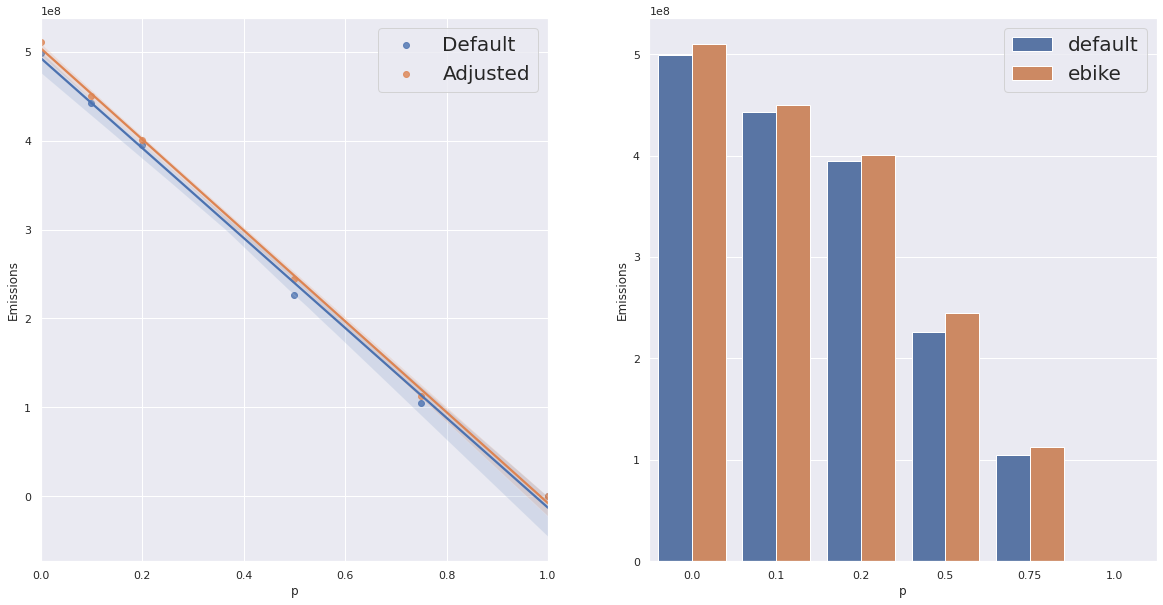

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Emissions')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Emissions')
sns.regplot(x=bar_p[:6], y=emissions_val[:6], label='Default', ax=axes[0])
sns.regplot(x=bar_p[6:], y=emissions_val[6:], label='Adjusted', ax=axes[0])
sns.barplot(x=bar_p, y=emissions_val, hue=bar_roadnet, ax=axes[1])
axes[1].legend(prop={'size': 20})
axes[0].legend(prop={'size': 20})

This figure shows the relationship between emissions and the rate at which vehicles leave the system using the time-based approximation. As is expected, more e-bikes lead to fewer emissions. However, recalling the possibility that e-bikes force cars to wait longer to turn, these data would suggest that results in higher emissions.

<br>

## Tracking Average Travel Time by Map

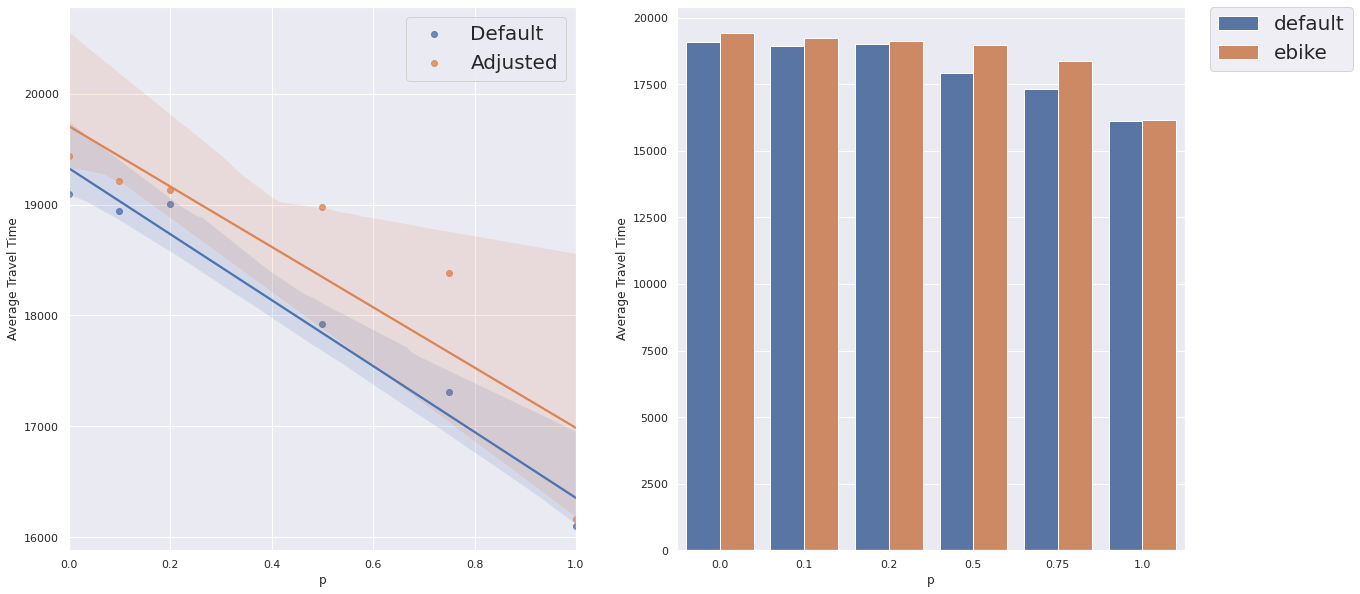

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Average Travel Time')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Average Travel Time')
sns.regplot(x=bar_p[:6], y=time_val[:6], label='Default', ax=axes[0])
sns.regplot(x=bar_p[6:], y=time_val[6:], label='Adjusted', ax=axes[0])
sns.barplot(x=bar_p, y=time_val, hue=bar_roadnet, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
axes[0].legend(prop={'size': 20})

This figure shows the average travel time for vehicles as e-bike proportion is increased. The interesting takeaway from this data is that in the scenario with bike-specific lanes, increasing the e-bike proportion does not greatly change the average travel time. 

<br>

## Tracking Average Travel Time by Vehicle Type on Default Map

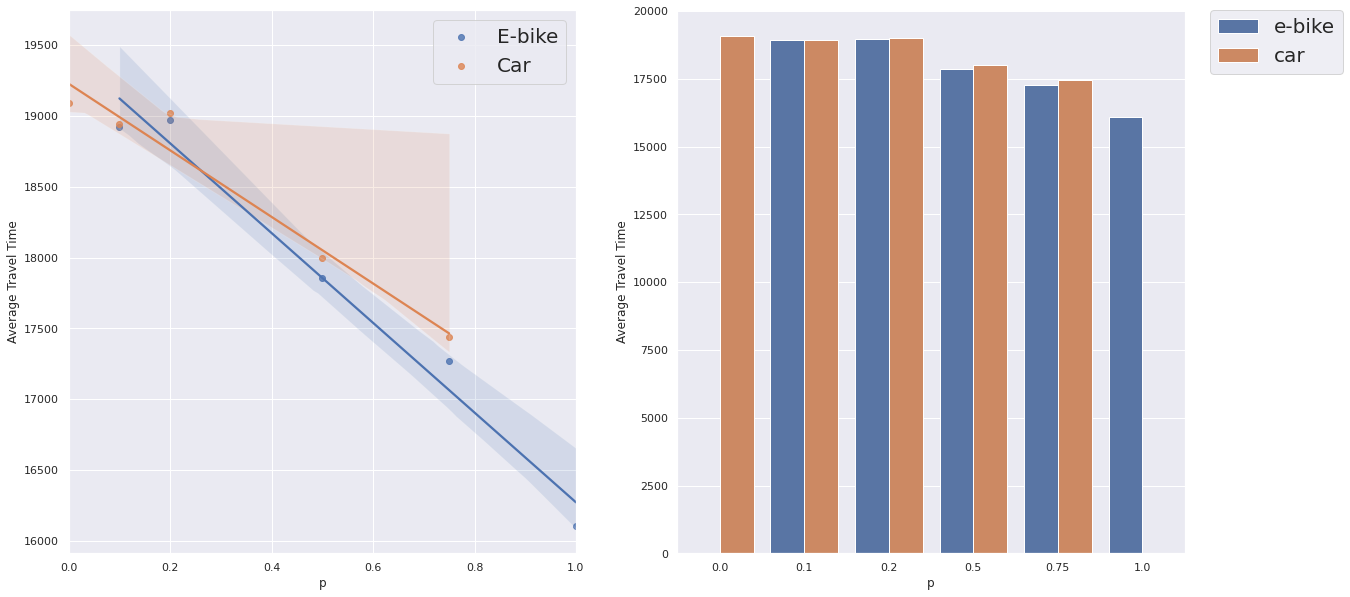

In [14]:
times = []
vehicle = []
p_list = []
ebike_times = []
ebike_p = []
car_times = []
car_p = []

for p in [0, .1, .2, .5, .75, 1]:
    if default_data['default'][p]['mean_ebike_time'] != 0:
        ebike_times.append(default_data['default'][p]['mean_ebike_time'])
        ebike_p.append(p)
    
    times.append(default_data['default'][p]['mean_ebike_time'])
    vehicle.append('e-bike')
    p_list.append(p)
    
for p in [0, .1, .2, .5, .75, 1]:
    if default_data['default'][p]['mean_car_time'] != 0:
        car_times.append(default_data['default'][p]['mean_car_time'])
        car_p.append(p)
    
    times.append(default_data['default'][p]['mean_car_time'])
    vehicle.append('car')
    p_list.append(p)
    
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Average Travel Time')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Average Travel Time')
sns.regplot(x=ebike_p, y=ebike_times, label='E-bike', ax=axes[0])
sns.regplot(x=car_p, y=car_times, label='Car', ax=axes[0])
sns.barplot(x=p_list, y=times, hue=vehicle, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
axes[0].legend(prop={'size': 20})

This figure shows the average travel time grouped by vehicle type on the default map. Although e-bikes start off taking slightly slonger than cars to travel through the simulation, as their share of traffic increases, they begin to move faster than cars. This could be due to easier lane changing since e-bikes are smaller and more maneuverable.

<br>

## Tracking Average Travel Time by Vehicle Type on Adjusted Map

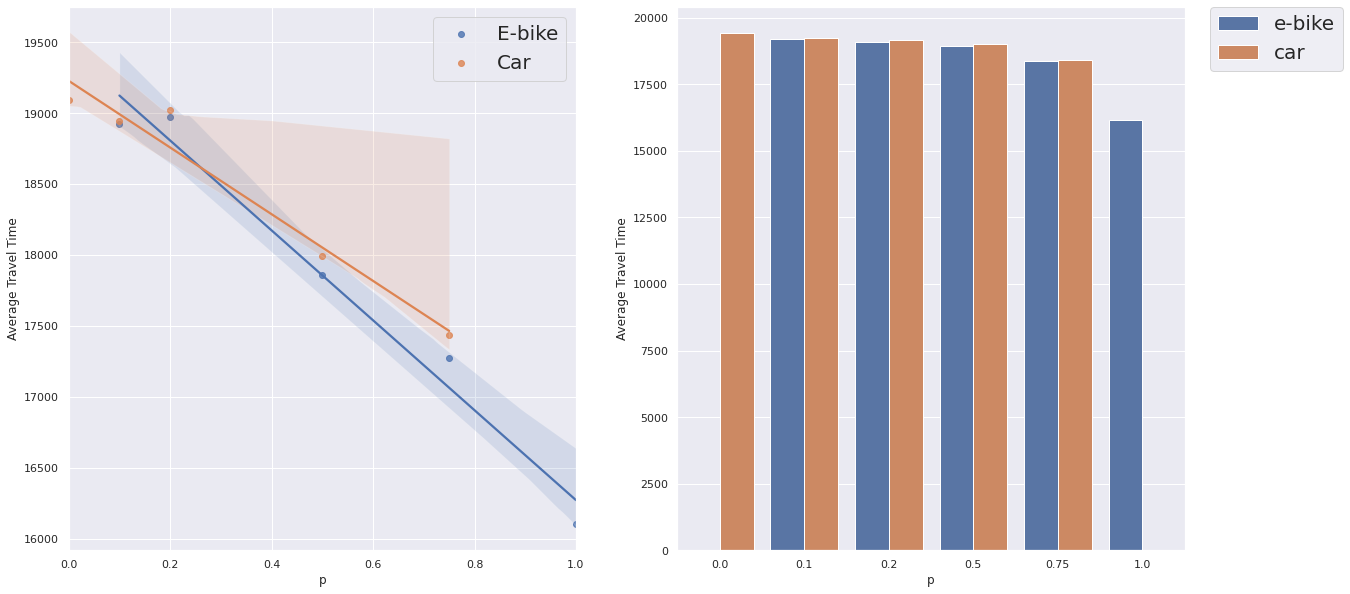

In [16]:
times = []
vehicle = []
p_list = []
ebike_times = []
ebike_p = []
car_times = []
car_p = []
for p in [0, .1, .2, .5, .75, 1]:
    try:
        if default_data['ebike'][p]['mean_ebike_time'] != 0:
            ebike_times.append(default_data['default'][p]['mean_ebike_time'])
            ebike_p.append(p)

        times.append(default_data['ebike'][p]['mean_ebike_time'])
        vehicle.append('e-bike')
        p_list.append(p)
    except:
        pass
    
for p in [0, .1, .2, .5, .75, 1]:
    try:
        if default_data['ebike'][p]['mean_car_time'] != 0:
            car_times.append(default_data['default'][p]['mean_car_time'])
            car_p.append(p)

        times.append(default_data['ebike'][p]['mean_car_time'])
        vehicle.append('car')
        p_list.append(p)
    except:
        pass
    
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_xlabel('p')
axes[0].set_ylabel('Average Travel Time')
axes[1].set_xlabel('p')
axes[1].set_ylabel('Average Travel Time')
sns.regplot(x=ebike_p, y=ebike_times, label='E-bike', ax=axes[0])
sns.regplot(x=car_p, y=car_times, label='Car', ax=axes[0])
sns.barplot(x=p_list, y=times, hue=vehicle)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
axes[0].legend(prop={'size': 20})

This figure shows the average travel time grouped by vehicle type on the default map. It is slightly similar to the pattern from the previous figure, but shows that a larger proportion of the vehicles on the road need to be e-bikes in order to see improvement. 

<br>

# Verification and Validation

## Verification

My initial plan was to use CityFlow as a simulation environment as is. However, I discovered that it was not capable of handling this specific task by default. I discovered that CityFlow did not enforce the condition that lanes have to be wider than the cars that travel on them. I had to modify the source code in order to restrict cars to the car specific lanes and keep them from traveling in the bike lanes as set up. This created an interesting situation regarding the types of lanes. Using my rule of replacing the right-most lane with a bicycle lane, I could inadvertently create a situation in which a car might not be able to take the same route it would have before. This could happen if I replaced a right-turn lane with a bike-only lane, for example. This meant I had to create an exception for cars merging into bike lanes when they need to turn right. This is consistent with the real world. In places where bike lanes are directly adjacent to car lanes, cars are required to merge into the bike lane and then turn right. I discovered this problem by running some basic experiments on a smaller example simulation. A snippet of results from that simulation can be found below. This is what the simulation looks like when correctly implemented. I reduced the width of the rightmost lane on all the roads to below the width of a car. As can be seen by focusing on any of the right turns in the gif, cars move along the regular lanes until shortly prior to the turn before merging into the bike lane temporarily to turn. They then move to the outermost allowable car lane on the road to which they are turning. This gif was recorded from the front-end visualization software that is included with CityFlow

## Validation

I used a combination of face and behavior validation to ensure the output was correct. I was unable to perform replicative validation due to compute power limitations. I was running large simulations over long periods of simulated time on the equipment available to me, which was my personal laptop. As such, I was unable to run multiple trials and collect statistical information. The only sources of stochasticity is the way in which vehicles are assigned to flows and the specific lanes they are initialized into within a road, but this is still something that should be tested to be robust. In order to test this, I would run multiple iterations with different random seeds and average together the results. I could then calculate confidence intervals for the bar plots and use them to better determine the effects of the proposed changes. However, I feel reasonably confident using the data that is available since I do not see any aberrant results that would require multiple trials.

### Start Up Time

As with all simulations, there is a period of time in which the simulation is warming up and new entities are being introduced. Unlike other simulations, however, I have a specific time at which this period ends. Vehicles are no longer introduced to the simulation after time 3878. This provides a time at which I can split in order to analyze summary statistics like average travel time and number of active vehicles.


### Face Validation

The face validation was done by looking at simulation outputs such as the one above to ensure that proper rules were being followed and there were no large issues with the traffic flow. Some other useful face validation was ensuring that emission numbers were at 0 for e-bike only flows. Out of the multiple probability runs, a probability of 1 for e-bike selection was the one case in which I could be sure about what the emissions value should be.

### Behavior Validation

Some basic behavior validation I performed was ensuring that fewer cars led to fewer emissions. In addition, I knew that reducing the number of lanes while keeping car traffic constant would increase congestion. This is measured as comparing the values from the default map using no e-bikes and the adjusted map with no e-bikes. As can be seen, the active vehicle numbers are higher and vehicle decrease rates are lower for the default map than the adjusted map for specifically the no e-bikes case. Another piece of validation that may lean more into analysis is that allowing vehicles to move closer together leads to more throughput. E-bikes can safely drive closer to each other than cars can while not driving much slower in the city, creating increased throughput.


<br>

# Conclusion

The data from the simulation results shows that it is not preferable to replace one car lane with a bike lane per road if the car traffic quantity is expected to stay the same. Given the quantitative information available, I could not recommend going forward with this proposal without further investigation. What needs to be studied further is the effect of removing car lanes and adding bike lanes on the proportion of traffic that is accounted for by cars. What this simulation did not account for is public transportation and its effects. It is possible that removing car lanes could convince people who would have driven to switch to bikes or to ride public transportation, thereby lowering congestion. As the proportionate share of e-bikes increases on the road, throughput also increases and travel time decreases, as can be seen in the data. A conclusion that can be definitively reached, unlike the effects of lane replacement, is that more e-bikes leads to better traffic flow. These data show that cities should invest in encouraging e-bike use, although lane replacement may not be the best option possible. Other possibilties to be considered are to add an entirely new lane by taking a small amount of space away from the other lanes on the road. The question to be addressed by future investigation is the percentage increase in e-bike share of the road that replacing car lanes with bike lanes can create. I believe this will be a positive number and could offset the issues that appear in these results, but that requires further examination. 

# References

Zhang, H., Feng, S., Liu, C., Ding, Y., Zhu, Y., Zhou, Z., Zhang, W., Yu, Y., Jin, H., & Li, Z. (2019). CityFlow: A Multi-Agent Reinforcement Learning Environment for Large Scale City Traffic Scenario. The World Wide Web Conference.


Chen, C., Wei, H., Xu, N., Zheng, G., Yang, M., Xiong, Y., Xu, K., & Li, Z. (2020). Toward A Thousand Lights: Decentralized Deep Reinforcement Learning for Large-Scale Traffic Signal Control. Proceedings of the AAAI Conference on Artificial Intelligence, 34(04), 3414-3421.
